In [607]:
import sys
sys.path.append('/mnt/disk01/note/workspaces/duxinxian')
import pandas as pd
import numpy as np
import os
import datetime
import scorecardpy as sc
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from unity import feature_selector as fs
from unity.fea_eda_func import FeaEdaFunc

pd.set_option('max_rows',200)

In [3]:
cust_main = pd.read_csv('data/sxd_cust_tag.csv')

In [4]:
cust_main['obs_dt'] = cust_main['obs_dt'].astype(str)

## 1.专家特征处理匹配

In [429]:
edf = pd.read_excel('data/eprt_fea/sxd_zj.xlsx')

In [430]:
ind = pd.read_excel('data/eprt_fea/东方微银贷后指标.xlsx')

In [431]:
cus_busid = pd.read_csv('data/cust_busid.csv')

In [432]:
cus_busid.head()

,req_id,customerid,businessid
0,12021063017581003436,4500413770,TCL20210600002432
1,12021063017491003435,4500413879,TCL20210600002437
2,12021063016071003421,4500413413,TCL20210600002418
3,12021063013581003370,3000780287,TCL20210600002398
4,12021063017291003433,4500413822,TCL20210600002436


In [433]:
edf.head()

,businessid,WN_BNK001,WN_BNK007,WN_BNK033,WN_BNK043,warn_month,WN_ECR075,WN_ECR011,WN_ECR028,WN_ECR038,...,ICR0021,XIB017,XIB033,XIB036,XIB045,XIB024,XIB049,ICR0003,label,warn_state
0,TCL20180900000092,0,0,0,0,2018-10-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCL20180900000092,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCL20180900000145,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCL20180900000145,0,0,0,0,2018-12-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCL20180900000145,0,0,0,0,2019-01-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [434]:
edf['warn_month'] = edf['warn_month'].astype('datetime64[ns]')

In [435]:
cust_main['obj_date'] = pd.to_datetime(cust_main['obs_dt'], format='%Y%m%d')
cust_main['cust_no'] = cust_main['cust_no'].astype(str)
cust_main = cust_main.sort_values(['cust_no','obj_date'])

NameError: name 'cust_main' is not defined

In [ ]:
cus_busid = cus_busid.rename({'customerid':'cust_no'},axis=1)
cus_busid['cust_no'] = cus_busid['cust_no'].astype(str)

In [ ]:
edf = cus_busid.merge(edf)
edf = edf.rename({'warn_month':'obj_date'},axis=1)
edf = edf.sort_values(['cust_no','obj_date'])
# edf['obs_dt'] = edf['obj_date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

In [ ]:
edf['p'] = 0
edf.loc[edf['obj_date'] <= '2019-12-31','p'] = 1
edf.loc[(edf['obj_date'] > '2019-12-31')&(edf['obj_date'] <= '2020-03-31'),'p'] = 2
edf.loc[(edf['obj_date'] > '2020-03-31')&(edf['obj_date'] <= '2020-06-30'),'p'] = 3
edf = edf[edf['p'] != 0]

In [ ]:
edfp = edf.groupby(['cust_no','p']).last().reset_index()

In [ ]:
cust_main['p'] = 0
cust_main.loc[cust_main['obj_date'] == '2019-12-31','p'] = 1
cust_main.loc[cust_main['obj_date'] == '2020-03-31','p'] = 2
cust_main.loc[cust_main['obj_date'] == '2020-06-30','p'] = 3

In [ ]:
main_df = cust_main.merge(edfp.loc[:, ~edfp.columns.str.contains('obs_dt|obj_date')],on=['cust_no','p'],how='left')

In [ ]:
# TODO:专家特征匹配缺失,cm_retail_lon_acct合同号（cont_no）与进件中的businessid是一个字段

In [ ]:
main_df[main_df['businessid'].isnull()]

## 2.行为特征匹配

In [ ]:
xw1 = pd.read_csv('data/bhv_fea/sxd_xw_1.csv')
xw2 = pd.read_csv('data/bhv_fea/sxd_xw_2.csv')
xw1.loc[:,['cust_no','obs_dt']] = xw1.loc[:,['cust_no','obs_dt']].astype(str)
xw2.loc[:,['cust_no','obj_date']] = xw2.loc[:,['cust_no','obj_date']].astype(str)

In [ ]:
xw2.rename({'obj_date':'obs_dt'},axis=1,inplace=True)

In [ ]:
main_df = main_df.merge(xw1,on=['cust_no','obs_dt'],how = 'left')
main_df = main_df.merge(xw2,on=['cust_no','obs_dt'],how = 'left')

In [ ]:
# null_cnt = main_df.isnull().sum()/4189
# null_cnt[null_cnt>0.5]

In [ ]:
main_df.head()

## 3.征信特征匹配

In [ ]:
zxfea = pd.read_csv('data/zxfea.csv')
zxvar = pd.read_csv('data/zxfea_var.csv')

In [ ]:
zxvar['var'] = zxvar['var'].str.lower()

In [ ]:
zxfea = zxfea.rename({'customer_no':'cust_no'},axis=1).drop(['tag','rn1','id_no','product_code','biz_date'],axis=1)

In [ ]:
zxfeas_set = set(zxfea.columns) & set(zxvar['var'])
zxfeas_set = zxfeas_set | {'cust_no','obs_dt'}

In [ ]:
zxfea = zxfea[zxfeas_set]
zxfea.loc[:,['cust_no','obs_dt']] = zxfea.loc[:,['cust_no','obs_dt']].astype(str)

In [ ]:
main_df = main_df.merge(zxfea,on=['cust_no','obs_dt'])

In [ ]:
main_df = main_df.drop(['label_1m','label'],axis=1)

In [ ]:
fea_types = main_df.dtypes
fea_types[fea_types == 'object']

In [195]:
main_df.to_csv('main_df.csv',index=False)

## 3.特征工程

### 3.1 数据清洗-剔除单一特征与缺失率超过0.7的特征

In [1313]:
main_df = pd.read_csv('main_df.csv')

/home/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (323,386,387,397,420,425,507,539,556,564,568,576,599,630,637,646) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1314]:
main_df = main_df.replace([-9988,-9989],np.nan)

In [1315]:
fsc = fs.FeatureSelector(main_df,labels='tag')

In [1316]:
fsc.identify_missing(0.7)
fsc.identify_single_unique()
# fsc.identify_collinear(0.9)

300 features with greater than 0.70 missing values.

121 features with a single unique value.



In [1317]:
remove_feas = fsc.check_removal()

Total of 394 features identified for removal


In [1318]:
main_df = main_df.drop(remove_feas,axis=1)

In [1319]:
train_set = main_df[main_df['obj_date'] != '2020-06-30']
oot_set = main_df[main_df['obj_date'] == '2020-06-30']

In [1320]:
train_set['tag'].value_counts()

0    1801
1     200
Name: tag, dtype: int64

In [1321]:
oot_set['tag'].value_counts()

0    1312
1     148
Name: tag, dtype: int64

In [1322]:
train_set['tag'].value_counts()/len(train_set)

0    0.90005
1    0.09995
Name: tag, dtype: float64

In [1323]:
train_set = train_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)
oot_set = oot_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)

### 3.2 类别变量处理

In [1324]:
from unity.eda_func import EdaFunc

In [1325]:
# train_set['dubil_num_3'].astype(float)

In [1326]:
fea_types = train_set.dtypes
fea_types[fea_types == 'object']

WN_TAX008    object
area         object
dtype: object

In [1327]:
train_set['area'] = train_set['area'].replace({'上海':1,'厦门':2,'福建':3})
oot_set['area'] = oot_set['area'].replace({'上海':1,'厦门':2,'福建':3})

In [1328]:
unique_feas = ['count_normalpayoff_loan_3', 'count_normalpayoff_loan_6', 'count_normalpayoff_loan_9', 'count_normalpayoff_loan_12', 
               'count_ovduepayoff_loan_3', 'count_ovduepayoff_loan_6', 'count_ovduepayoff_loan_9', 'count_ovduepayoff_loan_12',
               'zxgcsste','WN_ICR022', 'WN_ICR040', 'WN_LEG039', 'WN_LEG033', 'warn_state']
train_set = train_set.drop(unique_feas,axis=1)
oot_set = oot_set.drop(unique_feas,axis=1)

In [1329]:
train_set.shape

(2001, 248)

In [1330]:
oot_set.shape

(1460, 248)

### 3.3 划分样本

In [1331]:
tra_x,tst_x,tra_y,tst_y = train_test_split(train_set,train_set['tag'],shuffle=True,test_size=0.3,random_state=2)
oot_x = oot_set.copy()
oot_y = oot_set['tag']

In [1332]:
tra_y.value_counts()

0    1253
1     147
Name: tag, dtype: int64

In [1333]:
tst_y.value_counts()

0    548
1     53
Name: tag, dtype: int64

* <font size=4 color=red face=仿宋>直接先用树模型筛选特征</font>

In [1334]:
cat_feas = ['WN_BNK007','WN_TAX008','tag']
tra_x = tra_x.drop(cat_feas,axis=1)
tst_x = tst_x.drop(cat_feas,axis=1)
oot_x = oot_x.drop(cat_feas,axis=1)

In [1335]:
# tra_x = tra_x.apply(lambda x:x.fillna(x.median()))
# tst_x = tst_x.apply(lambda x:x.fillna(x.median()))
# oot_x = oot_x.apply(lambda x:x.fillna(x.median()))

# tra_x = tra_x.apply(lambda x:x.replace({np.inf:x.median()}))
# tst_x = tst_x.apply(lambda x:x.replace({np.inf:x.median()}))
# oot_x = oot_x.apply(lambda x:x.replace({np.inf:x.median()}))

#### 交叉验证筛选特征

In [1336]:
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=2)

In [1337]:
# sele = set()
# n = 1
# for tra_index,tst_index in skf.split(tra_x,tra_y):
#     print(f'第{n}折')
#     ktrax = tra_x.iloc[tra_index,:]
#     ktray = tra_y.iloc[tra_index]
#     ktstx = tra_x.iloc[tst_index,:]
#     ktxty = tra_y.iloc[tst_index]
#     clf = RandomForestClassifier(random_state=2)
#     clf.fit(ktrax,ktray)
#     imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
#     sele = sele | set(imp['importance'].head(50).index)
#     n+=1

In [1338]:
# tra_x = tra_x.drop('tag',axis=1)
# tst_x = tst_x.drop('tag',axis=1)
clf = LGBMClassifier(random_state=2,)
clf.fit(tra_x,tra_y)
tra_pred_y = clf.predict_proba(tra_x)[:,1]
imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
sele = set(imp['importance'].head(100).index)

In [1339]:
tra_x = tra_x[sele]
tst_x = tst_x[sele]
oot_x = oot_x[sele]

In [1340]:
# tra_x = tra_x.drop(hcorr_lis,axis=1)
# tst_x = tst_x.drop(hcorr_lis,axis=1)
# oot_x = oot_x.drop(hcorr_lis,axis=1)

In [1341]:
# clf.fit(tra_x,tra_y)
# tra_pred_y = clf.predict_proba(tra_x)[:,1]
# tst_pred_y = clf.predict_proba(tst_x)[:,1]
# oot_pred_y = clf.predict_proba(oot_x)[:,1]

In [1342]:
# sc.perf_eva(tra_y,tra_pred_y)   

In [1343]:
# sc.perf_eva(tst_y,tst_pred_y)   

In [1344]:
# sc.perf_eva(oot_y,oot_pred_y)    

### 3.3 决策树分箱

In [1345]:
tra_x = pd.concat([tra_x,tra_y],axis=1)
tst_x = pd.concat([tst_x,tst_y],axis=1)
oot_x = pd.concat([oot_x,oot_y],axis=1)

In [1346]:
tra_x.loc[tra_x['WN_TAX017'].isnull(),'WN_TAX017']

56     NaN
2647   NaN
2817   NaN
3103   NaN
2917   NaN
2657   NaN
2713   NaN
2500   NaN
2894   NaN
2002   NaN
2823   NaN
2622   NaN
2326   NaN
2732   NaN
1100   NaN
Name: WN_TAX017, dtype: float64

In [1347]:
bins_dic  =sc.woebin(tra_x,y='tag',method='tree')

[INFO] creating woe binning ...
Binning on 1400 rows and 101 columns in 00:00:14


### 3.4 剔除iv < 0.05的特征

In [1348]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)

In [1349]:
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
WN_ICR043,False,0.509032
WN_TAX017,False,0.415453
WN_TAX019,False,0.350115
WN_TAX024,False,0.343480
zxysavgloanbalanceamt,False,0.340203
WN_TAX025,False,0.338106
zxcrdpctallcurccpr,False,0.268688
WN_TAX027,False,0.268683
zxcrdpctrmbcurccpr,False,0.262416


In [1275]:
bins_dic['WN_TAX034']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,WN_TAX034,missing,615,0.439286,540,75,0.121951,0.168782,0.013374,0.131784,missing,True
1,WN_TAX034,"[-inf,1.0000000000000002)",247,0.176429,214,33,0.133603,0.273395,0.014681,0.131784,1.0000000000000002,False
2,WN_TAX034,"[1.0000000000000002,1.6000000000000003)",239,0.170714,216,23,0.096234,-0.096921,0.001543,0.131784,1.6000000000000003,False
3,WN_TAX034,"[1.6000000000000003,2.200000000000001)",140,0.100000,133,7,0.050000,-0.801576,0.046913,0.131784,2.200000000000001,False
4,WN_TAX034,"[2.200000000000001,2.700000000000001)",75,0.053571,69,6,0.080000,-0.299484,0.004268,0.131784,2.700000000000001,False
5,WN_TAX034,"[2.700000000000001,inf)",84,0.060000,81,3,0.035714,-1.152973,0.051004,0.131784,inf,False


In [1350]:
#替换inf值
tra_x['WN_TAX027']=tra_x['WN_TAX027'].replace(np.inf,9999999)
tra_x['WN_MIX027']=tra_x['WN_MIX027'].replace(np.inf,9999999)
tra_x['WN_TAX017']=tra_x['WN_TAX017'].replace(np.inf,9999999)
tra_x['WN_MIX017']=tra_x['WN_MIX017'].replace(np.inf,9999999)
tra_x = tra_x.apply(lambda x:x.replace({np.inf:9999999}))

{'WN_TAX034': <Figure size 432x288 with 2 Axes>}

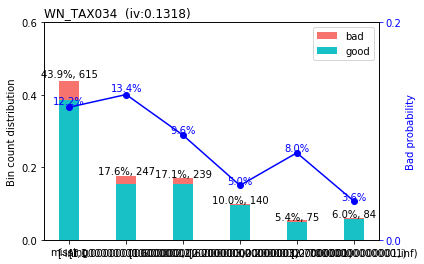

In [1274]:
sc.woebin_plot(bins_dic,x=['WN_TAX034'])

In [1351]:
adj_bin = sc.woebin(tra_x,x=['WN_ICR043','WN_TAX017','WN_TAX019','WN_TAX024','zxysavgloanbalanceamt','WN_TAX027','WN_TAX011','WN_TAX029','zxnmlccusedamt','zxutpggt6uplpr','zxshdprmbcuraccpr','WN_MIX027','rh_tot_card_max_balance_m24','zxactpccnrmaxgtu','WN_MIX017','rh_clear_loan_num_m24','zxpayamtminstallcurplpr','rh_tot_used_limit_rate','zxage','WN_ICR004','zxatc12mlmaxmobplpr'],y='tag',
                    breaks_list={'WN_ICR043':[1,4,9],'WN_TAX017':[-0.5,4],'WN_TAX019':[-0.3,-0.1,2],'WN_TAX024':[0.7,1.3,1.7,4,5],
                                 'zxysavgloanbalanceamt':[80000,320000,420000,800000],
                                 'WN_TAX027':[-0.7,-0.3,1.2],
                                 'WN_TAX011':[50000,550000],'WN_TAX029':[10000,40000,80000],'zxnmlccusedamt':[50000,200000,450000,750000],'zxutpggt6uplpr':[1,2],'zxshdprmbcuraccpr':[150,400,800],'WN_MIX027':[0,0.1,0.2],'rh_tot_card_max_balance_m24':[10000,70000,150000],'zxactpccnrmaxgtu':[0.5,1],'WN_MIX017':[0.1,0.2],
'rh_clear_loan_num_m24':[4,15,36],'zxpayamtminstallcurplpr':[100,1000,2000],'rh_tot_used_limit_rate':[0.3,0.6,1],'zxage':[38,42,48],'WN_ICR004':[-0.15,0,0.1],'zxatc12mlmaxmobplpr':[8,11]})

[INFO] creating woe binning ...


In [1352]:
adj_bin1 = sc.woebin(tra_x,x=['zxcrdpctrmbcurccpr','x1_4','WN_ICR056','WN_TAX036','x3_4','lon_amt_12','zxcaavgstrmbcurccpr','WN_TAX012','x1_2','zxcaavgstallcurccpr','x3_2','zxracallpr','WN_TAX035','WN_MIX025','zxutlpctallcuraccpr','zxutlpctrmbcuraccpr','zxpayamtmaxstallcuraccpr','zxcasumstallcurccpr','WN_TAX034'],y='tag',breaks_list={'zxcrdpctrmbcurccpr':[15,35,80],'x1_4':[1000,4500,5500],'WN_ICR056':[1,2],'WN_TAX036':[-0.8,-0.5,0],'x3_4':[10000,15000,20000,27000],'lon_amt_12':[250000,750000],'zxcaavgstrmbcurccpr':[20000,50000,90000],'WN_TAX012':[100000,500000,1300000],'x1_2':[3000,6500],'zxcaavgstallcurccpr':[20000,50000,100000],'x3_2':[10000,16000],'zxracallpr':[150000,310000,480000,700000],'WN_TAX035':[-0.8,0.2],'WN_MIX025':[0.1,0.35,1.6],'zxutlpctallcuraccpr':[25,50,75],'zxutlpctrmbcuraccpr':[25,75,90],'zxpayamtmaxstallcuraccpr':[2300,19000],'zxcasumstallcurccpr':[100000,300000,635000,900000],'WN_TAX034':[1,1.6,2.7]})

[INFO] creating woe binning ...


{'WN_TAX034': <Figure size 432x288 with 2 Axes>}

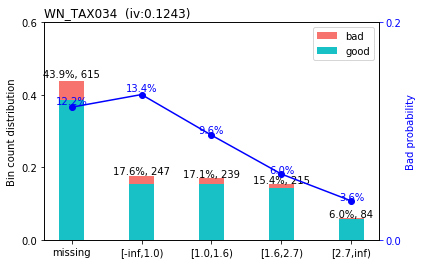

In [1279]:
sc.woebin_plot(adj_bin1,x=['WN_TAX034'])

In [1353]:
bins_dic.update(adj_bin)

In [1354]:
bins_dic.update(adj_bin1)

KeyError: 0

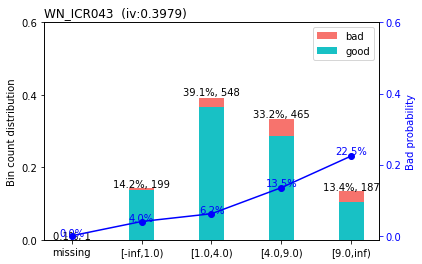

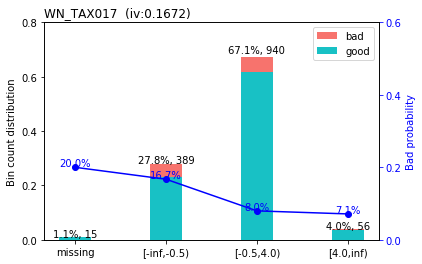

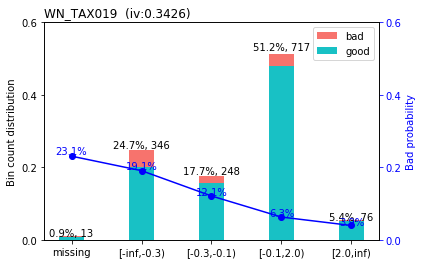

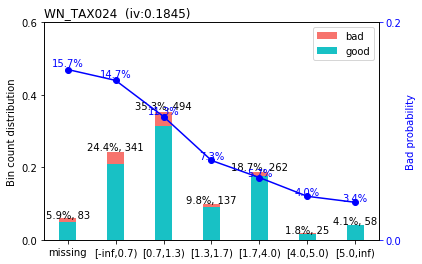

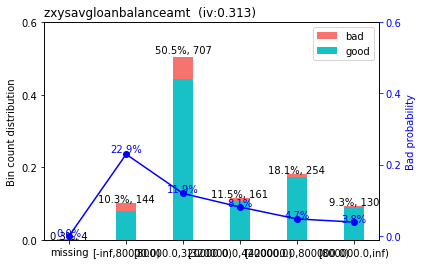

In [578]:
sc.woebin_plot(adj_bin,x=['WN_ICR043','WN_TAX017','WN_TAX019','WN_TAX024','zxysavgloanbalanceamt','zxcrdpctallcurccpr','WN_TAX027','WN_TAX011','WN_TAX029','zxnmlccusedamt','zxutpggt6uplpr','zxshdprmbcuraccpr','WN_MIX027','rh_tot_card_max_balance_m24','zxactpccnrmaxgtu','WN_MIX017','rh_clear_loan_num_m24','zxpayamtminstallcurplpr','rh_tot_used_limit_rate','zxage','WN_ICR004','zxatc12mlmaxmobplpr'])

{'zxatc12mlmaxmobplpr': <Figure size 432x288 with 2 Axes>}

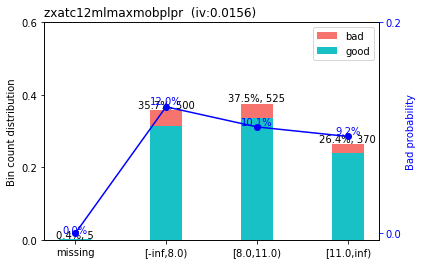

In [475]:
sc.woebin_plot(adj_bin,x=['zxatc12mlmaxmobplpr'])

In [579]:
tra_x['WN_TAX027'].value_counts()

-1.000000e+00    118
 9.999999e+06     22
 5.357380e-01      1
 2.570788e+01      1
 1.824836e+00      1
                ... 
 2.654557e+00      1
 2.827883e-01      1
-9.862144e-01      1
-6.692691e-01      1
 4.430861e+00      1
Name: WN_TAX027, Length: 1245, dtype: int64

In [580]:
# sc.woebin_plot(bins_dic,x=['sum_nopayoff_amt_loan_rate_12','sum_nopayoff_amt_loan_rate_6','sum_nopayoff_amt_loan_rate_3',
#                            'count_nopayoff_loan_rate_6','count_payoff_loan_12','zxcaminstallcuraccpr'])

In [1355]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)
fea_info = fea_info.sort_values('iv',ascending=False)
ivdrop_feas = fea_info[fea_info['iv'] < 0.05].index.to_list()

In [1356]:
tra_x = tra_x.drop(ivdrop_feas,axis=1)
tst_x = tst_x.drop(ivdrop_feas,axis=1)
oot_x = oot_x.drop(ivdrop_feas,axis=1)

### 3.5 woe

In [1357]:
tra_x_woe = sc.woebin_ply(tra_x,bins_dic)
tst_x_woe = sc.woebin_ply(tst_x,bins_dic)
oot_x_woe = sc.woebin_ply(oot_x,bins_dic)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


### 3.6 剔除psi大于0.1的特征

In [1358]:
tst_bin_group = FeaEdaFunc.bin_group(tst_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')
oot_bin_group = FeaEdaFunc.bin_group(oot_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')

In [1359]:
def calc_psi(train_bin_dicts,test_bin_dicts):
    """
    根据分箱后的结果计算PSI
    test_bin_dicts 为woe后的结果
    """
    psi_dict = {}
    for k,te in test_bin_dicts.items():
        if 'woe' in k:
            k = k.split('_woe')[0]
            te = te.rename({'%s_woe' % k:k},axis=1).set_index(k)
            tr = train_bin_dicts[k].rename({'woe':k},axis=1).set_index(k)
        else:
            te = te.set_index(k)
            tr = train_bin_dicts[k].set_index(k)
        pair = pd.concat([te['count_distr'],tr['count_distr']],axis=1,keys=['test','train'])
        psi = sum(((pair['test']-pair['train'])*(np.log(pair['test']/pair['train']))).dropna())
        psi_dict[k] = psi
    return psi_dict

In [1360]:
psi_info1 = calc_psi(bins_dic,tst_bin_group)
psi_info2 = calc_psi(bins_dic,oot_bin_group)

In [1361]:
psi_df1 = pd.DataFrame(psi_info1,index=['psi']).T.sort_values('psi',ascending=False)
psi_df2 = pd.DataFrame(psi_info2,index=['psi']).T.sort_values('psi',ascending=False)

In [1362]:
psi_drop1 = set(psi_df1[psi_df1['psi']>0.1].index)
psi_drop2 = set(psi_df2[psi_df2['psi']>0.1].index)
psi_drop = psi_drop1 | psi_drop2

In [1363]:
psi_drop = [i+'_woe' for i in psi_drop]

In [1364]:
psi_drop

['WN_MIX025_woe',
 'zxppaccpr_woe',
 'zxuppaccpr_woe',
 'amtlosumstrmbcurhllo_woe',
 'dubil_num_6_woe',
 'WN_ICR119_woe',
 'WN_ICR042_woe',
 'WN_TAX017_woe',
 'WN_TAX035_woe',
 'WN_TAX033_woe',
 'WN_TAX029_woe',
 'WN_MIX018_woe',
 'zxuppallpr_woe',
 'WN_TAX034_woe',
 'zxcrecardusecreditrate_woe',
 'count_nopayoff_loan_9_woe',
 'WN_TAX036_woe',
 'WN_TAX030_woe',
 'WN_MIX023_woe',
 'count_nopayoff_loan_6_woe',
 'WN_TAX026_woe']

### 3.7 共线性剔除 

In [1365]:
tra_x_woe.corr().style.background_gradient()

In [1366]:
tst_x_woe = tst_x_woe.drop(psi_drop,axis=1)
tra_x_woe = tra_x_woe.drop(psi_drop,axis=1)
oot_x_woe = oot_x_woe.drop(psi_drop,axis=1)

In [1367]:
tra_x_woe = tra_x_woe.drop('tag',axis=1).reset_index(drop=True)
tst_x_woe = tst_x_woe.drop('tag',axis=1).reset_index(drop=True)
oot_y = oot_x_woe['tag'].reset_index(drop=True)
oot_x_woe = oot_x_woe.drop('tag',axis=1).reset_index(drop=True)

## 3.初步测试

In [1368]:
def val_clf(x,y,oot_x,oot_y,score,clf=LGBMClassifier(),pert_func=sc.perf_eva):
    tra_x,tst_x,tra_y,tst_y = train_test_split(x,y,test_size=0.3,shuffle=True)
    clf.fit(tra_x,tra_y)
    pred_y = clf.predict_proba(tst_x)[:,1]
    oot_pred_y = clf.predict_proba(oot_x)[:,1]
    if pert_func:
        pert_func(tst_y,pred_y)
        pert_func(oot_y,oot_pred_y)
    else:
        print(score(tst_y,pred_y))

In [1370]:
tst_x_woe = tst_x_woe.apply(lambda x:x.fillna(x.median()))
oot_x_woe = oot_x_woe.apply(lambda x:x.fillna(x.median()))

In [1371]:
tra_x_woe.shape

(1400, 55)

In [1372]:
clf = LogisticRegression()
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
tst_pred_y = clf.predict_proba(tst_x_woe)[:,1]
oot_pred_y = clf.predict_proba(oot_x_woe)[:,1]

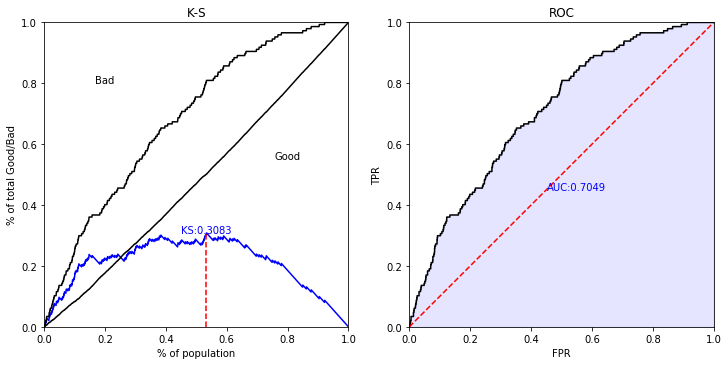

{'KS': 0.3083,
 'AUC': 0.7049,
 'Gini': 0.4098,
 'pic': <Figure size 864x432 with 2 Axes>}

In [1373]:
sc.perf_eva(tra_y,tra_pred_y)  

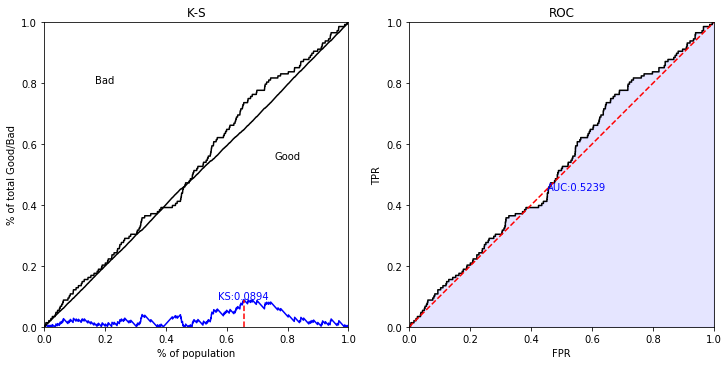

{'KS': 0.0894,
 'AUC': 0.5239,
 'Gini': 0.0478,
 'pic': <Figure size 864x432 with 2 Axes>}

In [1374]:
sc.perf_eva(oot_y,oot_pred_y)                                                                                                                                   

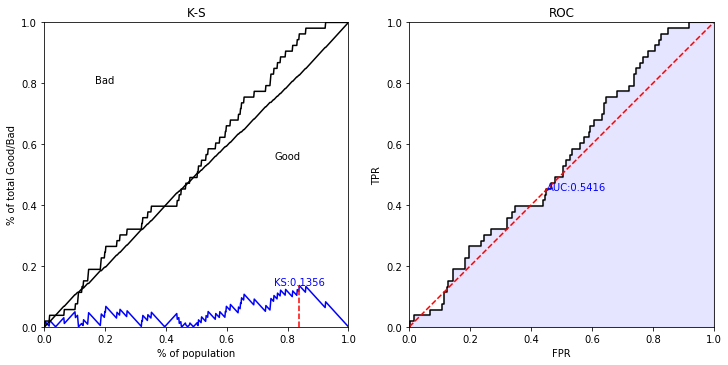

{'KS': 0.1356,
 'AUC': 0.5416,
 'Gini': 0.0833,
 'pic': <Figure size 864x432 with 2 Axes>}

In [1375]:
sc.perf_eva(tst_y,tst_pred_y)  